#### 1-D Range Tree

The 1D range tree on a set of points $P$ is a weight-balanced BST (weight balanced means that for any internal node in the tree, the number of nodes in it's left and right subtrees can differ by at most 1). We construct such a BST by first sorting the points in ascending order, then assigning the median of the sorted points as the root, then creating a left partition containing all points to the left of the median and a right partition on all points to the right. Then we assign the median from the left parititon as the left child of the root and the median of the right partition as the right child. We can then recursively apply this procedure individually on each partition.

The range tree supports a `range query operation` which takes a range $Q=[a,b]$ and reports all points from $P$ which are inside this range, i.e. it returns the set $P \cap Q$. We note that, $P \cap Q = P \cap Q'$ where $Q'=[a', b'] =[successor(a),predecessor(b)]$. To implement this operation, we start by first finding $a'$, $b'$ and their lowest common ancestor ($LCA$). The sub-tree rooted at the $LCA$ must contain all points that are in the range. First, we note that $a \leq LCA \leq b$, which means that node $LCA$ must be in $Q$. Now let $L_a$ be the path from the left child of the $LCA$ to $a'$ and let $L_b$ be the path from the right child of the $LCA$ to $b'$. Then we note that for any node $u$ on the path $L_a$, if $a \leq u$, then $u$ and all nodes in it's right-subtree must be in $Q$ (because $a \leq u < LCA$ and for every node $v$ in the right subtree of $u$, we know that $u < v < LCA$). Similarly, for any node $u$ on the path $L_b$, if $u \leq b$, then $u$ and all nodes in it's left-subtree must be in $Q$ (because $LCA < u \leq b$ and for every node $v$ in the left subtree of $u$, we know that $LCA < v < u$). So by finding $a'$, $b'$, $LCA$ and all nodes on the paths $L_a$ and $L_b$, we can also find all nodes in $Q$.

In [72]:
from collections import defaultdict
from graphviz import Digraph, Source
import random

def add_nodes_edges(graph, node, counter=0):
    if node is not None:
        root = str(counter)
        graph.node(root, str(node.key), fontsize='10')
        if node.left is not None:
            left = str(counter + 1)
            graph.edge(root, left)
            counter = add_nodes_edges(graph, node.left, counter + 1)
        else:
            if node.right is not None:
                # Add a dummy node if the node has no left child
                left = str(counter + 1)
                graph.node(left, "null")
                graph.edge(root, left)
                counter += 1

        if node.right is not None:
            right = str(counter + 1)
            graph.edge(root, right)
            counter = add_nodes_edges(graph, node.right, counter + 1)
        else:
            if node.left is not None:    
                # Add a dummy node if the node has no right child
                right = str(counter + 1)
                graph.node(right, "null")
                graph.edge(root, right)
                counter += 1

    return counter

def visualize_tree(root):
    graph = Digraph()
    add_nodes_edges(graph, root)
    return Source(graph.source)  


In [73]:
class Node:
    def __init__(self, key, data=None, parent=None, left=None, right=None):
        self.key = key
        self.data = data
        self.parent = parent
        self.left = left
        self.right = right


class range1d:
    def __init__(self, P):
        self.size = len(P)
        self.root = self.construct_wbst(P)

    @property
    def get_root(self):
        return self.root

    # function for constructing a weight-balanced binary search tree on a set of keys
    def construct_wbst(self, P):    
        # first sort the keys in acsending order
        P.sort()
        # recursively build the tree
        root = self.wbst(P, 0, len(P)-1)
        return root

    # recursive function for constructing a weight-balanced binary search tree
    def wbst(self, P, lo, hi):
        # find the median of the sorted keys
        m = (lo+hi+1) // 2
        # create a node with the median key
        node = Node(P[m])
        # recursively build the left subtree
        if lo < m:
            node.left = self.wbst(P, lo, m-1)
            node.left.parent = node
        if hi > m:
            node.right = self.wbst(P, m+1, hi)
            node.right.parent = node

        return node     

    # bst search for a given key
    def search(self, key):
        node = self.root
        while node is not None:
            if key < node.key:
                node = node.left
            elif key > node.key:
                node = node.right    
            else:
                return node    
        return None     
    

    # report all keys in the range [x1, x2]
    def report_range(self, Q):
        x1, x2 = Q
        # first find the successor(x1) and predecessor(x2)
        a = self.find_successor(x1)
        b = self.find_predecessor(x2)
        # find LCA
        lca = self.find_lca(a, b)

        print(f"Q = [{x1}, {x2}]")
        print(f"Q' = [{a.key}, {b.key}]")
        print(f"LCA = {lca.key}")

        # walk up from a to LCA, collecting all keys in the path which are in the range [x1, x2]
        range_nodes_left = []
        node = a
        while node != lca:
            if node.key >= x1:
                range_nodes_left.append(node)
                if node.right is not None:
                    range_nodes_left.extend(self.report_subtree(node.right))

            node = node.parent


        # walk up from b to LCA, collecting all keys in the path which are in the range [x1, x2]
        range_nodes_right = []
        node = b
        while node != lca:
            if node.key <= x2:
                range_nodes_right.append(node)
                if node.left is not None:
                    range_nodes_right.extend(self.report_subtree(node.left))

            node = node.parent

        range_nodes_right.reverse()
        range_nodes = range_nodes_left + [lca] + range_nodes_right
        range_points = [n.key for n in range_nodes]
        
        print(f"Points in the range [{x1}, {x2}] are: {range_points}")

        return range_points


    # report all nodes in the subtree rooted at a given node
    def report_subtree(self, node):
        subtree_nodes = [node]
        # perform level order traversal/BFS to get all nodes in the subtree
        queue = [node]
        while len(queue) > 0:
            node = queue.pop(0)
            if node.left is not None:
                queue.append(node.left)
                subtree_nodes.append(node.left)
            if node.right is not None:
                queue.append(node.right)
                subtree_nodes.append(node.right)

        return subtree_nodes    

    # find lowest common ancestor of two nodes in the tree
    def find_lca(self, a, b):
        node = self.root
        while True:
            if node.key > a.key and node.key > b.key:
                node = node.left
            elif node.key< a.key and node.key < b.key:
                node = node.right
            else:
                return node        

    # find predecessor of a given key
    def find_predecessor(self, key):
        node = self.root
        predecessor = None
        while node is not None:
            if key < node.key:
                node = node.left
            elif key > node.key:
                predecessor  = node
                node = node.right    
            else:
                return node    
        
        return predecessor
    
    # find successor of a given key
    def find_successor(self, key):
        node = self.root
        successor = None
        while node is not None:
            if key < node.key:
                successor = node
                node = node.left
            elif key > node.key:
                node = node.right    
            else:
                return node    
        
        return successor



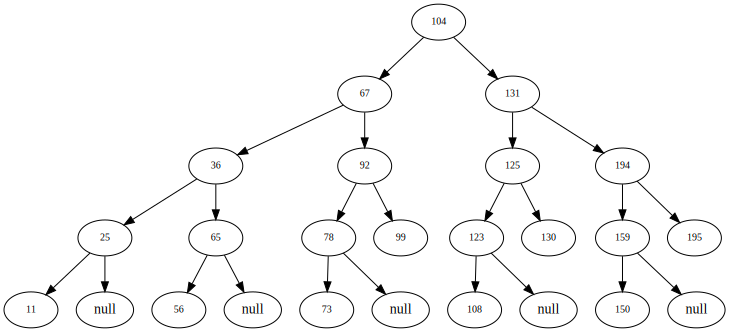

In [74]:
# test the implementation of the WBST
N = 20

random.seed(0)

# draw random integers between 0 and 100 without replacement
P = random.sample(range(1,200), N)
tree = range1d(P)

visualize_tree(tree.get_root)

In [75]:
range_nodes = tree.report_range((77, 130))

Q = [77, 130]
Q' = [78, 130]
LCA = 104
Points in the range [77, 130] are: [78, 92, 99, 104, 108, 123, 125, 130]
